# Human Player Test for State Punishment Game

This notebook allows you to play the State Punishment Game as a human player. You can test different configurations:
- **Composite Views**: See the world from multiple agent perspectives
- **Multi-Environment Composite**: Observe multiple environments simultaneously
- **Composite Actions**: Combine movement and voting in single actions

## Game Rules:
- **Movement**: Use WASD keys to move around
- **Voting**: Use Q/E keys to vote on punishment levels
- **Resources**: Collect resources (A, B, C, D, E) but beware of punishment!
- **Punishment**: Taboo resources trigger punishment based on current punishment level
- **Social Harm**: Your actions affect other agents through social harm


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import os

# Add parent directory to path for imports
sys.path.append(str(Path.cwd().parent))

# sorrel imports
from sorrel.examples.state_punishment_beta.entities import EmptyEntity
from sorrel.examples.state_punishment_beta.env import StatePunishmentEnv, MultiAgentStatePunishmentEnv
from sorrel.examples.state_punishment_beta.world import StatePunishmentWorld
from sorrel.examples.state_punishment_beta.agents import StatePunishmentAgent
from sorrel.action.action_spec import ActionSpec
from sorrel.observation.observation_spec import OneHotObservationSpec
from sorrel.models.human_player import HumanPlayer, HumanObservation
from sorrel.utils.visualization import render_sprite, image_from_array


In [13]:
%load_ext autoreload
%autoreload 2

# Exclude problematic modules from autoreload
%aimport -tensorboard
%aimport -tensorboard.compat
%aimport -tensorboard.compat.tensorflow_stub


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuration

Set your preferred game mode here:


In [14]:
# Game Configuration
USE_COMPOSITE_VIEWS = True      # Set to True to see from multiple agent perspectives
USE_COMPOSITE_ACTIONS = False    # Set to True to combine movement + voting
USE_MULTI_ENV_COMPOSITE = False  # Set to True to observe multiple environments
NUM_AGENTS = 3                   # Number of agents (including human player)
MAX_TURNS = 50                   # Maximum turns per game

print(f"Game Configuration:")
print(f"  Composite Views: {USE_COMPOSITE_VIEWS}")
print(f"  Composite Actions: {USE_COMPOSITE_ACTIONS}")
print(f"  Multi-Env Composite: {USE_MULTI_ENV_COMPOSITE}")
print(f"  Number of Agents: {NUM_AGENTS}")
print(f"  Max Turns: {MAX_TURNS}")


Game Configuration:
  Composite Views: True
  Composite Actions: False
  Multi-Env Composite: False
  Number of Agents: 3
  Max Turns: 50


## Custom Human Player for State Punishment

This custom human player handles the specific requirements of the State Punishment Game:


In [15]:
class StatePunishmentHumanPlayer(HumanPlayer):
    """Custom human player for State Punishment Game."""
    
    def __init__(self, input_size, action_space, memory_size, use_composite_views=False, use_composite_actions=False):
        super().__init__(input_size, action_space, memory_size)
        self.use_composite_views = use_composite_views
        self.use_composite_actions = use_composite_actions
        self.world = None
        self.agent = None
        
    def set_world_and_agent(self, world, agent):
        """Set world and agent references for visualization."""
        self.world = world
        self.agent = agent
    
    def take_action(self, state: np.ndarray):
        """Get action from human player with visualization."""
        if self.show and self.world is not None:
            from IPython.display import clear_output
            clear_output(wait=True)
            
            # Render the world
            self._render_world()
            
            # Show game state information
            self._show_game_info()
        
        # Get action from user
        action = self._get_user_input()
        return action
    
    def _render_world(self):
        """Render the current world state."""
        try:
            # Render the world with sprites
            layers = render_sprite(self.world, tile_size=[32, 32])
            composited = image_from_array(layers)
            
            plt.figure(figsize=(12, 10))
            plt.imshow(composited)
            plt.title(f"State Punishment Game - Turn {getattr(self.agent, 'turn', 0)}")
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
            
            # Add grid for better navigation
            plt.grid(True, alpha=0.3)
            plt.xticks(range(0, self.world.width + 1))
            plt.yticks(range(0, self.world.height + 1))
            
            plt.show()
            
        except Exception as e:
            print(f"Visualization error: {e}")
            # Fallback: show text representation
            self._show_text_world()
    
    def _show_text_world(self):
        """Show text representation of the world as fallback."""
        print("\nWorld State (Text Representation):")
        print("Legend: A=Agent, W=Wall, a,b,c,d,e=Resources, .=Empty")
        print("-" * (self.world.width + 2))
        
        for y in range(self.world.height):
            row = "|"
            for x in range(self.world.width):
                cell = self.world.map[y, x, 0]
                if hasattr(cell, 'kind'):
                    if cell.kind == 'Agent0':
                        row += "A"  # Human player
                    elif cell.kind in ['A', 'B', 'C', 'D', 'E']:
                        row += cell.kind.lower()
                    elif cell.kind == 'Wall':
                        row += "W"
                    else:
                        row += "."
                else:
                    row += "."
            row += "|"
            print(row)
        print("-" * (self.world.width + 2))
    
    def _show_game_info(self):
        """Show current game information."""
        if self.world and hasattr(self.world, 'state_system'):
            punishment_level = self.world.state_system.prob
            social_harm = self.world.get_social_harm(0) if hasattr(self.world, 'get_social_harm') else 0.0
            total_reward = getattr(self.world, 'total_reward', 0.0)
            
            print(f"\nGame Information:")
            print(f"  Punishment Level: {punishment_level:.3f}")
            print(f"  Social Harm: {social_harm:.3f}")
            print(f"  Total Reward: {total_reward:.2f}")
            
            if hasattr(self.agent, 'encounters'):
                print(f"  Resources Collected: {dict(self.agent.encounters)}")
    
    def _get_user_input(self):
        """Get action input from user."""
        if self.use_composite_actions:
            # Composite actions: movement + voting combined
            print("\nComposite Actions (Movement + Voting):")
            print("  Movement: w=up, s=down, a=left, d=right")
            print("  Voting: q=increase punishment, e=decrease punishment")
            print("  Combined: wq=up+increase, wd=up+decrease, etc.")
            print("  Or enter action number (0-12) or 'quit'")
            
            action_map = {
                'w': 0,   # up_no_vote
                's': 1,   # down_no_vote
                'a': 2,   # left_no_vote
                'd': 3,   # right_no_vote
                'wq': 4,  # up_increase
                'sq': 5,  # down_increase
                'aq': 6,  # left_increase
                'dq': 7,  # right_increase
                'we': 8,  # up_decrease
                'se': 9,  # down_decrease
                'ae': 10, # left_decrease
                'de': 11, # right_decrease
                ' ': 12   # noop
            }
        else:
            # Simple actions: separate movement and voting
            print("\nSimple Actions:")
            print("  Movement: w=up, s=down, a=left, d=right")
            print("  Voting: q=increase punishment, e=decrease punishment")
            print("  No action: space")
            print("  Or enter action number (0-6) or 'quit'")
            
            action_map = {
                'w': 0,   # up
                's': 1,   # down
                'a': 2,   # left
                'd': 3,   # right
                'q': 4,   # vote_increase
                'e': 5,   # vote_decrease
                ' ': 6    # noop
            }
        
        action = None
        num_retries = 0
        
        while not isinstance(action, int):
            action_input = input("Enter action: ").strip().lower()
            
            if action_input == 'quit':
                raise KeyboardInterrupt("Quitting...")
            elif action_input in action_map:
                action = action_map[action_input]
            elif action_input.isdigit() and 0 <= int(action_input) < self.action_space:
                action = int(action_input)
            else:
                num_retries += 1
                if num_retries > 5:
                    raise KeyboardInterrupt("Too many invalid inputs. Quitting...")
                print("Invalid input. Please try again.")
                print(f"Valid inputs: {list(action_map.keys())} or numbers 0-{self.action_space-1}")
        
        return action


## Custom Human Agent

This agent bypasses some of the learning mechanisms for human players:


In [16]:
class StatePunishmentHumanAgent(StatePunishmentAgent):
    """Custom agent for human players in State Punishment Game."""
    
    def __init__(self, observation_spec, action_spec, model, agent_id=0, **kwargs):
        super().__init__(observation_spec, action_spec, model, agent_id, **kwargs)
        self.human_player = model
    
    def get_action(self, state: np.ndarray) -> int:
        """Override get_action to work with human player."""
        # For human player, we don't need memory stacking
        # Just pass the state directly to the model
        action = self.model.take_action(state)
        return action
    
    def add_memory(self, state: np.ndarray, action: int, reward: float, done: bool) -> None:
        """Override add_memory for human player."""
        # Human players don't need to store experiences in memory
        pass
    
    def can_act(self) -> bool:
        """Override can_act to allow human player to always act."""
        return True


## Main Game Function

This function sets up and runs the game with human player:


In [17]:
def create_config(use_composite_views=False, use_composite_actions=False, use_multi_env_composite=False, num_agents=3, max_turns=50):
    """Create configuration for the human player test."""
    return {
        "experiment": {
            "epochs": 1,
            "max_turns": max_turns,
            "record_period": 1,
            "run_name": "human_player_test",
            "num_agents": num_agents,
            "initial_resources": 15,
        },
        "model": {
            "agent_vision_radius": 2,
            "epsilon": 0.0,  # No exploration for human player
            "epsilon_decay": 0.0,
            "full_view": True,
            "layer_size": 128,
            "n_frames": 1,  # Single frame for human player
            "n_step": 1,
            "sync_freq": 100,
            "model_update_freq": 4,
            "batch_size": 1,
            "memory_size": 1,
            "LR": 0.0,  # No learning for human player
            "TAU": 0.001,
            "GAMMA": 0.99,
            "n_quantiles": 8,
            "device": "cpu",
        },
        "world": {
            "height": 10,
            "width": 10,
            "a_value": 3.0,
            "b_value": 7.0,
            "c_value": 2.0,
            "d_value": -2.0,
            "e_value": 1.0,
            "spawn_prob": 0.05,
            "respawn_prob": 0.02,
            "init_punishment_prob": 0.1,
            "punishment_magnitude": -10.0,
            "change_per_vote": 0.1,
            "taboo_resources": ["A", "B", "C", "D", "E"],
            "entity_spawn_probs": {
                "A": 0.2, "B": 0.2, "C": 0.2, "D": 0.2, "E": 0.2
            }
        },
        "use_composite_views": use_composite_views,
        "use_composite_actions": use_composite_actions,
        "use_multi_env_composite": use_multi_env_composite,
    }


In [18]:
def main():
    """Run the human player test."""
    print("Setting up State Punishment Game with Human Player...")
    
    # Create configuration
    config = create_config(
        use_composite_views=USE_COMPOSITE_VIEWS,
        use_composite_actions=USE_COMPOSITE_ACTIONS,
        use_multi_env_composite=USE_MULTI_ENV_COMPOSITE,
        num_agents=NUM_AGENTS,
        max_turns=MAX_TURNS
    )
    
    # Create environments for each agent
    environments = []
    shared_state_system = None
    shared_social_harm = None
    
    for i in range(NUM_AGENTS):
        world = StatePunishmentWorld(config=config, default_entity=EmptyEntity())
        
        if shared_state_system is None:
            shared_state_system = world.state_system
        else:
            world.state_system = shared_state_system
        
        if shared_social_harm is None:
            shared_social_harm = world.social_harm
        else:
            world.social_harm = shared_social_harm
        
        # Create a modified config for this specific agent environment
        agent_config = dict(config)
        agent_config["experiment"]["num_agents"] = 1  # Each environment has only one agent
        agent_config["model"]["n_frames"] = 1  # Single frame per observation
        
        env = StatePunishmentEnv(world, agent_config)
        env.agents[0].agent_id = i
        environments.append(env)
    
    # Create the multi-agent environment
    multi_agent_env = MultiAgentStatePunishmentEnv(
        individual_envs=environments,
        shared_state_system=shared_state_system,
        shared_social_harm=shared_social_harm
    )
    
    # Replace the first agent with a human player
    human_world = environments[0].world
    
    # Create observation spec for human player
    entity_list = ["EmptyEntity", "Wall", "A", "B", "C", "D", "E"] + [f"Agent{i}" for i in range(NUM_AGENTS)]
    observation_spec = HumanObservation(
        entity_list=entity_list,
        full_view=True,
        env_dims=(config["world"]["height"], config["world"]["width"]),
    )
    
    # Create action spec
    if USE_COMPOSITE_ACTIONS:
        action_names = [
            "up_no_vote", "down_no_vote", "left_no_vote", "right_no_vote",
            "up_increase", "down_increase", "left_increase", "right_increase",
            "up_decrease", "down_decrease", "left_decrease", "right_decrease",
            "noop"
        ]
    else:
        action_names = ["up", "down", "left", "right", "vote_increase", "vote_decrease", "noop"]
    
    action_spec = ActionSpec(action_names)
    
    # Create human player
    human_player = StatePunishmentHumanPlayer(
        input_size=(config["world"]["height"], config["world"]["width"], 1),
        action_space=action_spec.n_actions,
        memory_size=1,
        use_composite_views=USE_COMPOSITE_VIEWS,
        use_composite_actions=USE_COMPOSITE_ACTIONS
    )
    
    # Create human agent
    human_agent = StatePunishmentHumanAgent(
        observation_spec=observation_spec,
        action_spec=action_spec,
        model=human_player,
        agent_id=0,
        use_composite_views=USE_COMPOSITE_VIEWS,
        use_composite_actions=USE_COMPOSITE_ACTIONS,
        use_multi_env_composite=USE_MULTI_ENV_COMPOSITE
    )
    
    # Set world and agent references for visualization
    human_player.set_world_and_agent(human_world, human_agent)
    
    # Replace the first agent with human player
    environments[0].agents[0] = human_agent
    
    # Set up multi-agent coordination
    for i, env in enumerate(environments):
        other_envs = [environments[j] for j in range(len(environments)) if j != i]
        env.agents[0].set_multi_agent_coordination(other_envs, shared_state_system, i)
    
    print(f"\nGame started! You are Agent 0 in a {NUM_AGENTS}-agent game.")
    print(f"Configuration: Composite Views={USE_COMPOSITE_VIEWS}, Composite Actions={USE_COMPOSITE_ACTIONS}")
    print(f"Maximum turns: {MAX_TURNS}")
    print("\nStarting game...")
    
    try:
        # Run the experiment
        multi_agent_env.run_experiment(logging=False, animate=False)
        
        print("\nGame completed!")
        print(f"Final punishment level: {shared_state_system.prob:.3f}")
        print(f"Your total reward: {human_world.total_reward:.2f}")
        
    except KeyboardInterrupt:
        print("\nGame interrupted by user.")
        print(f"Final punishment level: {shared_state_system.prob:.3f}")
        print(f"Your total reward: {human_world.total_reward:.2f}")
    except Exception as e:
        print(f"\nError during game: {e}")
        import traceback
        traceback.print_exc()


## Run the Game

Execute the cell below to start playing! Make sure you've set your preferred configuration above.


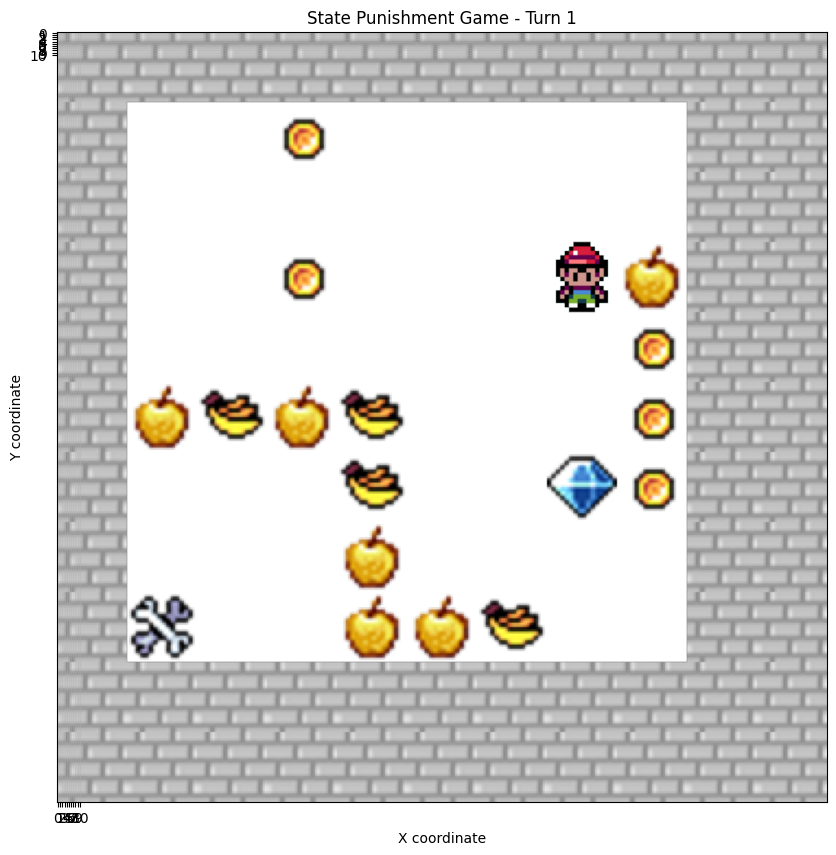


Game Information:
  Punishment Level: 0.100
  Social Harm: 0.000
  Total Reward: 0.00
  Resources Collected: {}

Simple Actions:
  Movement: w=up, s=down, a=left, d=right
  Voting: q=increase punishment, e=decrease punishment
  No action: space
  Or enter action number (0-6) or 'quit'

Error during game: 'StatePunishmentHumanAgent'


Traceback (most recent call last):
  File "C:\Users\22455\AppData\Local\Temp\ipykernel_13568\2565793405.py", line 110, in main
    multi_agent_env.run_experiment(logging=False, animate=False)
  File "D:\sorrel\sorrel\examples\state_punishment_beta\env.py", line 145, in run_experiment
    self.take_turn()
  File "D:\sorrel\sorrel\examples\state_punishment_beta\env.py", line 63, in take_turn
    agent.transition(env.world,
  File "D:\sorrel\sorrel\examples\state_punishment_beta\agents.py", line 359, in transition
    state = self.generate_multi_env_composite_state()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\sorrel\sorrel\examples\state_punishment_beta\agents.py", line 140, in generate_multi_env_composite_state
    env_state = self._observe_environment_from_other_agent_perspective(env.world)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\sorrel\sorrel\examples\state_punishment_beta\agents.py", line 182, in _observe_envir

In [19]:
main()


## Game Tips

### Strategy Tips:
1. **Start with low punishment**: Collect resources when punishment level is low
2. **Use voting strategically**: Vote to decrease punishment when you want to collect taboo resources
3. **Coordinate with other agents**: Your votes affect the global punishment level
4. **Watch social harm**: Your actions create social harm that affects other agents

### Resource Values:
- **A**: +3 points (taboo)
- **B**: +7 points (taboo)
- **C**: +2 points (taboo)
- **D**: -2 points (taboo, negative value!)
- **E**: +1 point (taboo)

### Punishment System:
- Punishment level starts at 0.1 (10%)
- Voting increases/decreases punishment by 0.2
- Higher punishment = more negative reward for collecting taboo resources
- Social harm accumulates based on your actions

### Controls:
- **Simple Actions**: w/s/a/d for movement, q/e for voting, space for no action
- **Composite Actions**: w/s/a/d for movement, add q for increase punishment, e for decrease punishment
- **Composite Views**: See the world from multiple agent perspectives (if enabled)
- **Multi-Env Composite**: Observe multiple environments simultaneously (if enabled)
